In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test,y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
height = x_train.shape[1]
width = x_train.shape[2]
channels = 1

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255
x_test = x_test/255

In [6]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2], channels)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2], channels)

In [7]:
x_train.shape

(60000, 28, 28, 1)

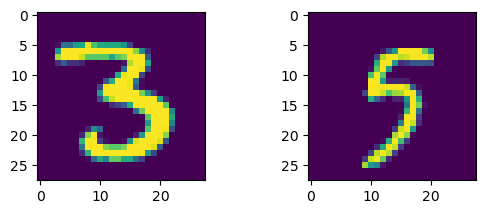

In [8]:
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[12])
plt.subplot(222)
plt.imshow(x_train[420])

# Define Encoder

In [9]:
input_layer = Input(shape=(height,width,channels), name="encoder")
x = Conv2D(32,3,padding='same',activation='relu')(input_layer)
x = Conv2D(64,3,padding='same',activation='relu')(x)
x = Conv2D(64,3,padding='same',activation='relu',strides=(2, 2))(x)
x = Conv2D(64,3,padding='same',activation='relu')(x)
x = Conv2D(32,3,padding='same',activation='relu',strides=(2, 2))(x)

In [10]:
conv_shape = K.int_shape(x)

In [11]:
conv_shape

(None, 7, 7, 32)

In [12]:
x= Flatten()(x)
x = Dense(32, activation='relu')(x)

## Define middle layer with 3 nodes for variational encoder

In [13]:
latent_space = 2
z_mu = Dense(latent_space)(x)
z_sigma = Dense(latent_space)(x)

In [14]:
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

In [15]:
z = Lambda(sample_z, output_shape = (latent_space,))([z_mu, z_sigma])

In [16]:
encoder = Model(input_layer, [z_mu,z_sigma,z])

In [17]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                              

# Decoder

In [18]:
decoder_input = Input(shape=(latent_space,), name = "decoder")
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1],conv_shape[2],conv_shape[3]))(x)
x = Conv2DTranspose(64,3,padding='same',activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(64,3,padding='same',activation='relu')(x)
x = Conv2DTranspose(64,3,padding='same',activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(32,3,padding='same',activation='relu')(x)
x = Conv2DTranspose(1,3,padding='same',activation='sigmoid')(x)
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 1568)              4704      
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       18496     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 64)       3692

In [19]:
decoded_z = decoder(z)

# Define loss layer

In [20]:
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [21]:
loss_layer = CustomLayer()([input_layer,decoded_z])

# Final Variational Encoder

In [22]:
vae = Model(input_layer, loss_layer, name='vae')
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                                

In [23]:
vae.fit(x_train, None, epochs = 22, batch_size = 32, validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/22
47904/48000 [============================>.] - ETA: 0s - loss: 0.2196

/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 25s 530us/sample - loss: 0.2196 - val_loss: 0.1984
Epoch 2/22
48000/48000 [==============================] - 14s 299us/sample - loss: 0.1963 - val_loss: 0.1937
Epoch 3/22
48000/48000 [==============================] - 14s 298us/sample - loss: 0.1916 - val_loss: 0.1888
Epoch 4/22
48000/48000 [==============================] - 14s 299us/sample - loss: 0.1889 - val_loss: 0.1878
Epoch 5/22
48000/48000 [==============================] - 14s 296us/sample - loss: 0.1869 - val_loss: 0.1856
Epoch 6/22
48000/48000 [==============================] - 15s 304us/sample - loss: 0.1854 - val_loss: 0.1848
Epoch 7/22
48000/48000 [==============================] - 15s 303us/sample - loss: 0.1841 - val_loss: 0.1844
Epoch 8/22
48000/48000 [==============================] - 15s 306us/sample - loss: 0.1832 - val_loss: 0.1822
Epoch 9/22
48000/48000 [==============================] - 15s 302us/sample - loss: 0.1824 - val_loss: 0.1821
Epoch 10/22
48000/48000 [=====

# Visualization

/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


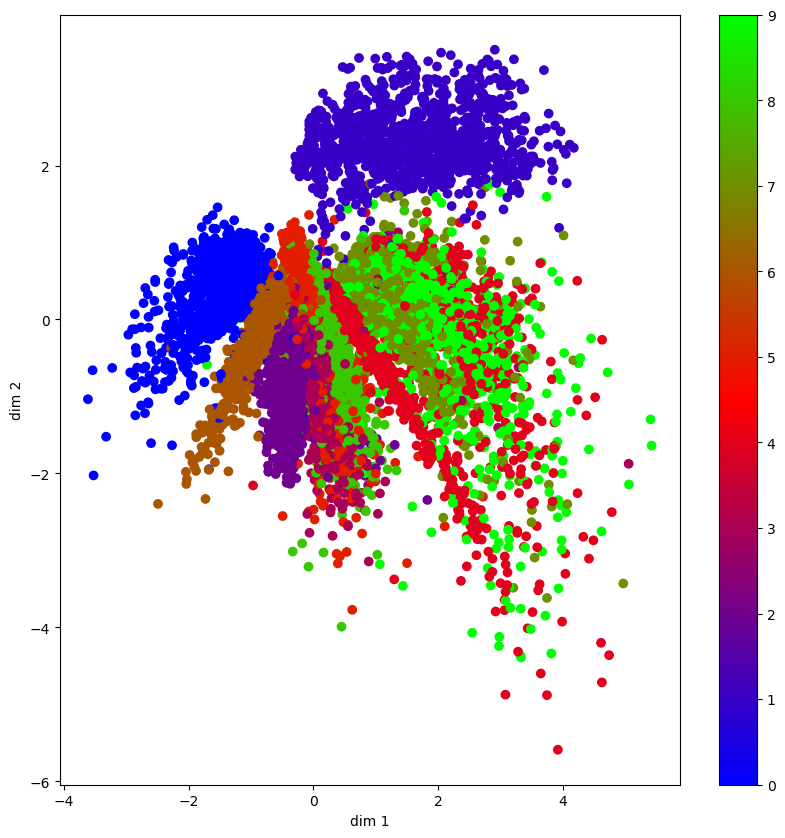

In [24]:
mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

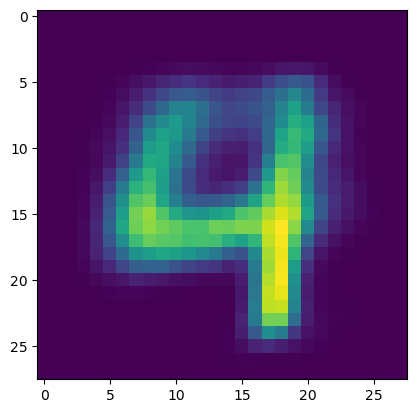

In [25]:
sample_vector = np.array([[2,-2]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(width, height)
plt.imshow(decoded_example_reshaped)

In [26]:
path = 'variational_autoencode.h5'

In [27]:
vae.save(path)

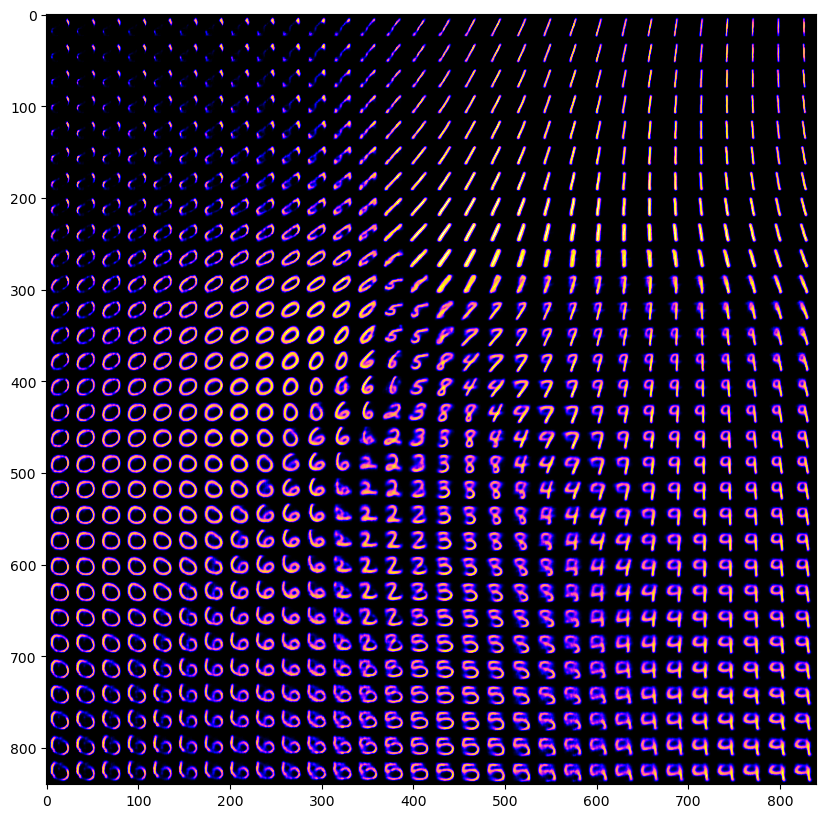

In [28]:
n = 30  # generate 15x15 digits
figure = np.zeros((width * n, height * n, channels))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(width, height, channels)
        figure[i * width: (i + 1) * width,
               j * height: (j + 1) * width] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()